## Model for imbalanced Dataset

In [1]:
# load libraries
import pandas as pd
import numpy as np
import plotly.express as px
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
import tqdm

### Train-Validation-Test Split

In [2]:
from UK_road_safety import UKRoadSafety

# load data
data = UKRoadSafety('../data/',years=[2023])

data.data_wrangling()

/home/ankit/DS_projects/UK_road_safety_modelling/notebooks/UK_road_safety.py:118: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.df[col].fillna(self.df[col].median(), inplace=True)
/home/ankit/DS_projects/UK_road_safety_modelling/notebooks/UK_road_safety.py:118: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting val

In [3]:


# test-train split
X_train, X_test, y_train, y_test = data.train_test_split()

# train-val split
X_train, X_val, y_train, y_val = data.train_test_split()


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (151852, 47)
y_train shape: (151852,)
X_val shape: (37963, 47)
y_val shape: (37963,)
X_test shape: (37963, 47)
y_test shape: (37963,)


### Baseline Model

In [4]:
# get maximum frequency of y as baseline model
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.78


### Decision Tree Model Hyperparameter tuning

In [7]:
# Create empty lists for training and validation accuracy scores
training_acc = []
validation_acc = []

# tree depth from 1 to 49 in steps of 2
depth_hyperparams=range(1,50,2)
for d in tqdm.tqdm(depth_hyperparams):
    # Create model with `max_depth` of `d`
    test_model = make_pipeline(
        # OneHotEncoder(use_cat_names=True),
        DecisionTreeClassifier(max_depth=d,random_state=42)
    )
    # Fit model to training data
    test_model.fit(X_train, y_train)
    # Calculate training accuracy score and append to `training_acc`
    
    training_acc.append(test_model.score(X_train,y_train))
    # Calculate validation accuracy score and append to `training_acc`
    
    validation_acc.append(test_model.score(X_val,y_val))

print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])


100%|██████████| 25/25 [11:02<00:00, 26.49s/it]

Training Accuracy Scores: [0.7778484650383247, 0.7779822833350152, 0.7800136889536287]
Validation Accuracy Scores: [0.7778450522547187, 0.777072858258527, 0.7796351383367994]


### Validation Curve

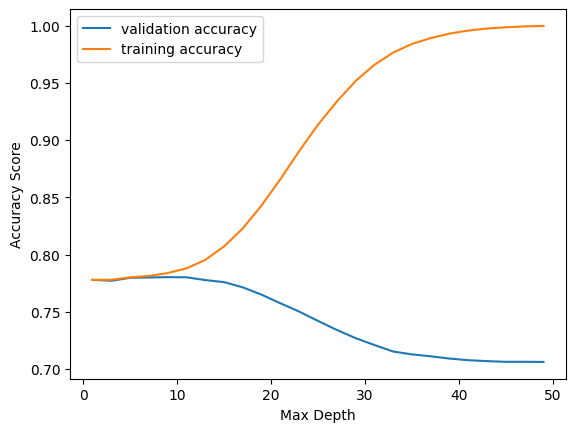

In [9]:
# Plot `depth_hyperparams`, `training_acc`
plt.plot(depth_hyperparams,validation_acc,label='validation accuracy')
plt.plot(depth_hyperparams,training_acc,label='training accuracy')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('Accuracy Score');

After a depth of 7-8 the curves start diverging so keeping the depth at 7

In [10]:
final_model = make_pipeline(
        # OrdinalEncoder(),
        DecisionTreeClassifier(max_depth=10,random_state=42)
    )
    # Fit model to training data
final_model.fit(X_train, y_train)

Pipeline(steps=[('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=10, random_state=42))])

In [11]:
# train accuracy
acc_train = final_model.score(X_train,y_train)
print("Train Accuracy:", round(acc_train, 2))
# validation accuracy
acc_val = final_model.score(X_val,y_val)
print("Validation Accuracy:", round(acc_val, 2))
# test accuracy
acc_test = final_model.score(X_test,y_test)
print("Test Accuracy:", round(acc_test, 2))

Train Accuracy: 0.79
Validation Accuracy: 0.78
Test Accuracy: 0.78


We are not able to do better than 71% using decision trees. Moreover the classification is for the imbalanced dataset. Let is try to handle the imbalance first

### Random Forest Model on imbalanced data

In [13]:

model_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features= "log2",
    random_state=42,n_jobs=-1)

# fit model to training data
model_rf.fit(X_train, y_train)

# accuracy
acc_train = model_rf.score(X_train,y_train)
print("Train Accuracy:", round(acc_train, 2))
# validation accuracy
acc_val = model_rf.score(X_val,y_val)
print("Validation Accuracy:", round(acc_val, 2))
# test accuracy
acc_test = model_rf.score(X_test,y_test)
print("Test Accuracy:", round(acc_test, 2))


Train Accuracy: 0.78
Validation Accuracy: 0.78
Test Accuracy: 0.78


It is clear that both the models were not able to improve the model. One reason for that is the imbalance in the target variable.

## Handling Imbalance

In [5]:
# over and under sampling

# under sampling
under_sampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under_sampler.fit_resample(X_train,y_train)
print(X_train_under.shape)

# over sampling
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
print(X_train_over.shape)


(6321, 47)
(351840, 47)


<Axes: xlabel='Frequency', ylabel='Accident Severity'>

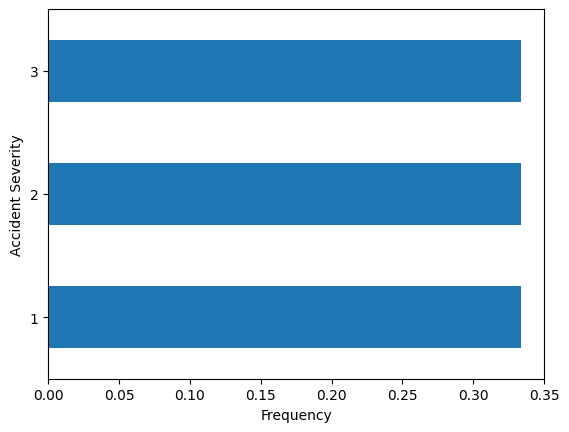

In [ ]:
y_train_over.value_counts(normalize=True).sort_index().plot.barh(xlabel='Frequency',ylabel='Accident Severity')

In [ ]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state=42)

# X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

<Axes: xlabel='Frequency', ylabel='Accident Severity'>

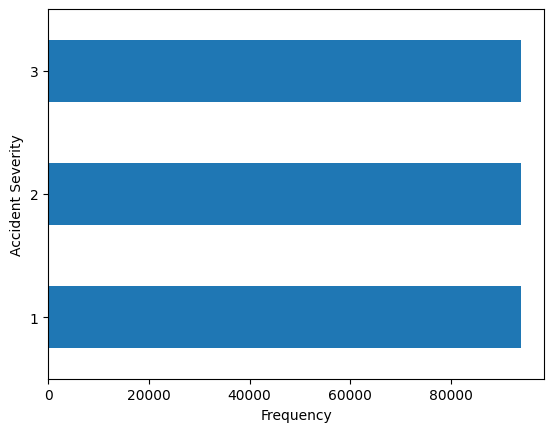

In [ ]:
y_train_over.value_counts().sort_index().plot.barh(xlabel='Frequency',ylabel='Accident Severity')

### Model for balanced dataset

In [ ]:
# Create empty lists for training and validation accuracy scores
training_acc = []
validation_acc = []

# tree depth from 1 to 49 in steps of 2
depth_hyperparams=range(1,50,2)
for d in tqdm.tqdm(depth_hyperparams):
    # Create model with `max_depth` of `d`
    test_model = make_pipeline(
        # OneHotEncoder(use_cat_names=True),
        DecisionTreeClassifier(max_depth=d,random_state=42)
    )
    # Fit model to training data
    test_model.fit(X_train_over, y_train_over)
    # Calculate training accuracy score and append to `training_acc`
    
    training_acc.append(test_model.score(X_train_over,y_train_over))
    # Calculate validation accuracy score and append to `training_acc`
    
    validation_acc.append(test_model.score(X_val,y_val))

print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])


100%|██████████| 25/25 [01:14<00:00,  3.00s/it]

Training Accuracy Scores: [0.45680512907994997, 0.4834385306493802, 0.5172260605026726]
Validation Accuracy Scores: [0.5541141220242995, 0.5322840867933226, 0.48213756544071645]


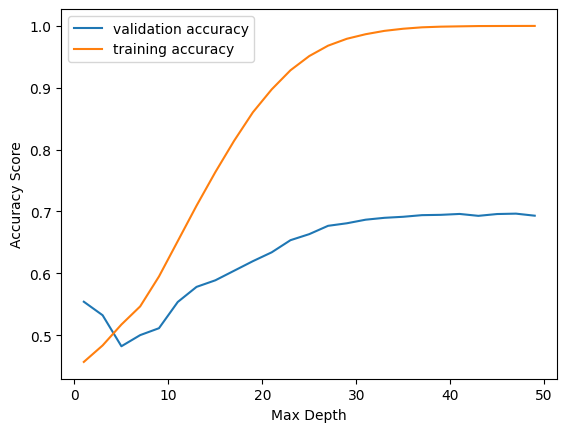

In [ ]:
# Plot `depth_hyperparams`, `training_acc`
plt.plot(depth_hyperparams,validation_acc,label='validation accuracy')
plt.plot(depth_hyperparams,training_acc,label='training accuracy')
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('Accuracy Score');

This is worse than baseline model.

## Random Forest Model

We will be using RandomForest classfier which is generally robust for imbalanced dataset and using cross validation along with grid search for tuning the hyperparameters

In [ ]:

clf = RandomForestClassifier(random_state=42)


param_grid = {
    "n_estimators": [100,200,300],
    "max_depth": [10,20,30],
    "min_samples_split": [10],
    "min_samples_leaf": [2,5,10],
    "max_features": [ "log2"]
}

grid = GridSearchCV(
    clf, param_grid,
    scoring="f1_weighted",  # better than accuracy for imbalance
    cv=3,
    n_jobs=-1
)

grid.fit(X_train_over, y_train_over)

# accuracy  
acc_train = grid.score(X_train,y_train)
print("Train Accuracy:", round(acc_train, 2))
# test accuracy
acc_test = grid.score(X_test,y_test)
print("Test Accuracy:", round(acc_test, 2))


/home/ankit/miniconda3/envs/UK/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Train Accuracy: 1.0
Test Accuracy: 0.75


Random Forest does not seem to be doing a good job than the decision tree model on beating the baseline

## LightGBM Model

In [ ]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Pre-split your data to avoid CV inside Optuna
X_tune, X_holdout, y_tune, y_holdout = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
from sklearn.metrics import recall_score

def objective(trial):
    params = {
        'objective': 'multiclass',
        'num_class': len(set(y_tune)),
        'metric': 'multi_logloss',  # keep for LightGBM, but won't drive Optuna
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'learning_rate': trial.suggest_float('learning_rate', 0.008, 0.1),
        'n_estimators': 150,
        'min_child_samples': trial.suggest_int('min_child_samples', 30, 100)
    }
    
    model = lgb.LGBMClassifier(**params)  # helps recall for minority
    model.fit(
        X_tune, y_tune,
        eval_set=[(X_holdout, y_holdout)],
        eval_metric='multi_logloss',
        callbacks=[lgb.early_stopping(stopping_rounds=20)]
    )
    preds = model.predict(X_holdout)
    return recall_score(y_holdout, preds, average='macro')  # 🔑 optimize macro recall

study = optuna.create_study(direction='maximize', study_name="maximize_macro_recall")
study.optimize(objective, n_trials=20)


print(study.best_params)


[I 2025-08-27 14:33:25,471] A new study created in memory with name: maximize_macro_recall


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[150]	valid_0's multi_logloss: 0.532986


[I 2025-08-27 14:33:49,760] Trial 0 finished with value: 0.3414583240584339 and parameters: {'num_leaves': 140, 'max_depth': 26, 'learning_rate': 0.008145488354945864, 'min_child_samples': 66}. Best is trial 0 with value: 0.3414583240584339.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[150]	valid_0's multi_logloss: 0.510817


[I 2025-08-27 14:34:07,707] Trial 1 finished with value: 0.3666270338116006 and parameters: {'num_leaves': 147, 'max_depth': 28, 'learning_rate': 0.0560405138187735, 'min_child_samples': 83}. Best is trial 1 with value: 0.3666270338116006.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[150]	valid_0's multi_logloss: 0.512374


[I 2025-08-27 14:34:21,705] Trial 2 finished with value: 0.36561271206321666 and parameters: {'num_leaves': 87, 'max_depth': 15, 'learning_rate': 0.07695947369160616, 'min_child_samples': 66}. Best is trial 1 with value: 0.3666270338116006.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[150]	valid_0's multi_logloss: 0.535182


[I 2025-08-27 14:34:39,018] Trial 3 finished with value: 0.3420469842070752 and parameters: {'num_leaves': 171, 'max_depth': 7, 'learning_rate': 0.011027376997884352, 'min_child_samples': 81}. Best is trial 1 with value: 0.3666270338116006.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[149]	valid_0's multi_logloss: 0.504177


[I 2025-08-27 14:35:00,080] Trial 4 finished with value: 0.37770278862958934 and parameters: {'num_leaves': 199, 'max_depth': 29, 'learning_rate': 0.09144832231394232, 'min_child_samples': 68}. Best is trial 4 with value: 0.37770278862958934.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[150]	valid_0's multi_logloss: 0.512331


[I 2025-08-27 14:35:19,674] Trial 5 finished with value: 0.3648038215584421 and parameters: {'num_leaves': 115, 'max_depth': 24, 'learning_rate': 0.05930470831727718, 'min_child_samples': 98}. Best is trial 4 with value: 0.37770278862958934.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[150]	valid_0's multi_logloss: 0.512072


[I 2025-08-27 14:35:41,120] Trial 6 finished with value: 0.3677291536730957 and parameters: {'num_leaves': 76, 'max_depth': 26, 'learning_rate': 0.09805022372726757, 'min_child_samples': 98}. Best is trial 4 with value: 0.37770278862958934.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[149]	valid_0's multi_logloss: 0.512321


[I 2025-08-27 14:35:56,475] Trial 7 finished with value: 0.36786087461727807 and parameters: {'num_leaves': 72, 'max_depth': 18, 'learning_rate': 0.09353083064601125, 'min_child_samples': 62}. Best is trial 4 with value: 0.37770278862958934.


Training until validation scores don't improve for 20 rounds


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

best_params = {
    'num_leaves': 192,
    'max_depth': 16,
    'learning_rate':  0.09966159921985593,
    'min_child_samples': 20,
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'verbosity': -1,
    'random_state': 42
}

final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Test Accuracy: 0.7863972815636278
              precision    recall  f1-score   support

           1       0.85      0.08      0.15       570
           2       0.65      0.14      0.23      8193
           3       0.79      0.98      0.88     29200

    accuracy                           0.79     37963
   macro avg       0.77      0.40      0.42     37963
weighted avg       0.76      0.79      0.73     37963



In [18]:
# check if X-train has any missing values
print("Missing values in X_train:", X_train.isnull().sum())

Missing values in X_train: location_easting_osgr                      27
location_northing_osgr                     27
longitude                                  27
latitude                                   27
police_force                                0
number_of_vehicles                          0
day_of_week                                 0
first_road_class                            0
first_road_number                           0
road_type                                   0
speed_limit                                 0
junction_detail                             0
junction_control                            0
second_road_class                           0
second_road_number                          0
pedestrian_crossing_human_control           0
pedestrian_crossing_physical_facilities     0
light_conditions                            0
weather_conditions                          0
road_surface_conditions                     0
special_conditions_at_site                  0
carriag

In [ ]:
# Required packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, recall_score
from imblearn.combine import SMOTETomek

# -----------------------------
# 1. Split dataset
# -----------------------------
X_train, X_test, y_train, y_test = data.train_test_split()


# -----------------------------
# 2. Apply SMOTETomek oversampling
# -----------------------------
smt = SMOTETomek(
    sampling_strategy={1: 100_000, 2: 250_000}, 
    random_state=42
)
X_res, y_res = smt.fit_resample(X_train, y_train)

# -----------------------------
# 3. Define base models
# -----------------------------
lgb_model = LGBMClassifier(
    objective='multiclass',
    num_class=len(np.unique(y_res)),
    boosting_type='gbdt',
    n_estimators=200,
    class_weight={1:5, 2:2, 3:1},  # Emphasize rare classes
    random_state=42
)

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    class_weight={1:5, 2:2, 3:1},
    random_state=42
)
estimators = [
    ('lgbm1', lgb.LGBMClassifier(num_class=3, objective='multiclass')),
    ('lgbm2', lgb.LGBMClassifier(num_class=3, objective='multiclass'))
]

ensemble = VotingClassifier(estimators=estimators, voting='soft')

# -----------------------------
# 5. Fit ensemble on oversampled data
# -----------------------------
ensemble.fit(X_res, y_res)

# -----------------------------
# 6. Predict probabilities
# -----------------------------
y_proba = ensemble.predict_proba(X_test)  # list of arrays per class

# -----------------------------
# 7. Threshold tuning for rare classes
# -----------------------------
# Example thresholds: lower threshold for class 1 to catch more rare events
thresholds = {1: 0.2, 2: 0.3, 3: 0.5}  

y_pred = []
for probs in y_proba:

    pred_class = ensemble.classes_[np.argmax(probs)]  # returns an array of predicted class indices
    # Adjust thresholds
    for cls, thr in thresholds.items():
        if probs[cls-1] >= thr:  # cls-1 because predict_proba is 0-indexed
            pred_class = cls
            break
    y_pred.append(pred_class)

# -----------------------------
# 8. Evaluate
# -----------------------------
print(classification_report(y_test, y_pred))
macro_recall = recall_score(y_test, y_pred, average='macro')
print("Macro Recall:", macro_recall)


## BalancedRandomForestClassifier

In [66]:
# 1️⃣ Imports
import numpy as np
import pandas as pd
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score

# # 2️⃣ Split your data
# X_train, X_test, y_train, y_test = train_test_split(
#     X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
# )

# 3️⃣ Initialize BalancedRandomForest
ensemble = BalancedRandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    sampling_strategy='auto',  # custom targets,
    max_features= "log2",
    min_samples_split=10,
    min_samples_leaf=5
)


# 4️⃣ Fit model
ensemble.fit(X_train, y_train)

# 5️⃣ Predict and evaluate
y_pred = ensemble.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))
macro_recall = recall_score(y_test, y_pred, average='macro')
print(f"Macro Recall: {macro_recall:.3f}")


              precision    recall  f1-score   support

           1      0.055     0.766     0.103      1630
           2      0.304     0.391     0.342     23687
           3      0.869     0.597     0.708     88644

    accuracy                          0.556    113961
   macro avg      0.410     0.584     0.384    113961
weighted avg      0.740     0.556     0.623    113961

Macro Recall: 0.584


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# 1️⃣ Build a two‐step sampler pipeline

smote = SMOTE(sampling_strategy={1: 8000, 2: 6000}, random_state=42),
    
under = RandomUnderSampler(sampling_strategy={3: 15000}, random_state=42),

lightgm = LGBMClassifier(
        n_estimators=300,
        max_depth=20,
        learning_rate=0.05,
        num_leaves=63,
        reg_lambda=1.0,
        class_weight={1: 35, 2: 5, 3: 1},
        objective='multiclass',
        random_state=42),
        
        
# clf = RandomForestClassifier(
#         n_estimators=500,
#         max_depth=None,
#         min_samples_split=10,
#         min_samples_leaf=5,
#         max_features='log2',
#         class_weight='balanced',
#         random_state=42,
#         n_jobs=-1  # parallelize *here*
#     )

pipeline = Pipeline([
("smote", (SMOTE(random_state=42, sampling_strategy={1: 8000, 2: 6000}),)), 
("under", under),
    ("clf", lightgm)
])


pipeline.fit(X_train, y_train)

# Predict probabilities
y_proba = pipeline.predict_proba(X_test)

# Plot PR curves for each class
classes = pipeline.named_steps['clf'].classes_
plt.figure(figsize=(8,6))
for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test == cls, y_proba[:, i])
    ap = average_precision_score(y_test == cls, y_proba[:, i])
    plt.plot(recall, precision, label=f"Class {cls} (AP={ap:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves by Class")
plt.legend()
plt.grid(True)
plt.show()



TypeError: All intermediate steps of the chain should be estimators that implement fit and transform or fit_resample (but not both) or be a string 'passthrough' '(SMOTE(random_state=42, sampling_strategy={1: 8000, 2: 6000}),)' (type <class 'tuple'>) doesn't)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.101643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2682
[LightGBM] [Info] Number of data points in the train set: 29000, number of used features: 47
[LightGBM] [Info] Start training from score -0.149036
[LightGBM] [Info] Start training from score -2.382628
[LightGBM] [Info] Start training from score -3.075775

Classification Report:
              precision    recall  f1-score   support

           1      0.058     0.743     0.107       533
           2      0.279     0.542     0.368      8125
           3      0.885     0.463     0.608     29305

    accuracy                          0.484     37963
   macro avg      0.407     0.583     0.361     37963
weighted avg      0.744     0.484     0.550     37963

Confusion Matrix:
[[  396   117    20]
 [ 1983  4404  1738]
 [ 4469 11270 13566]]


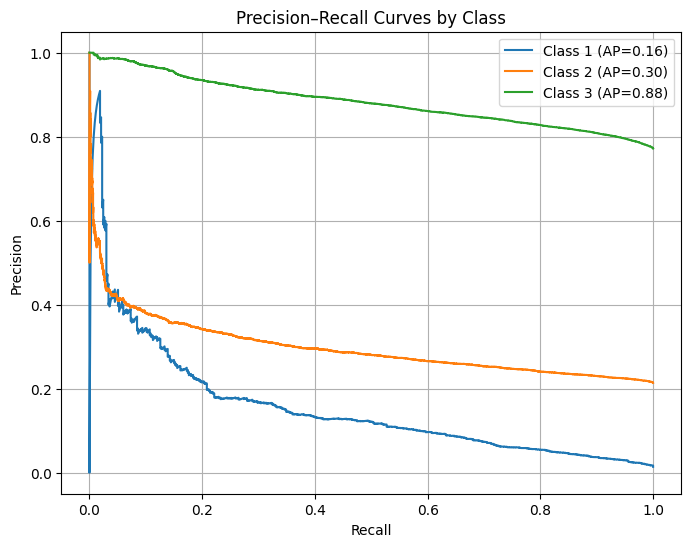


Custom threshold (0.2) applied for Fatal class — adjust in practice based on PR curve trade-offs.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from lightgbm import LGBMClassifier

# =========================
# 1. Load and prepare data
# =========================
# df = pd.read_csv("Accidents_2023.csv")  # Replace with your path
# X = df.drop("Accident_Severity", axis=1)
# y = df["Accident_Severity"]

# # Feature types
# cat_feats = X.select_dtypes(include="object").columns
# num_feats = X.select_dtypes(exclude="object").columns

# # Preprocessor
# preproc = ColumnTransformer([
#     ("cat", OneHotEncoder(handle_unknown='ignore'), cat_feats),
#     ("num", "passthrough", num_feats)
# ])

# =========================
# 2. Define samplers & model
# =========================
# Aggressive oversampling for Fatal (1) and Serious (2)
smote = SMOTE(sampling_strategy={1: 8000}, random_state=42)
# Strong undersampling for Slight (3)
under = RandomUnderSampler(sampling_strategy={2: 6000,3: 15000}, random_state=42)

# LightGBM with custom class weights
lgbm = LGBMClassifier(
    n_estimators=300,
    max_depth=20,
    learning_rate=0.05,
    num_leaves=63,
    reg_lambda=1.0,
    class_weight={1: 35, 2: 5, 3: 1},
    objective='multiclass',
    random_state=42
)

# =========================
# 3. Build pipeline
# =========================
pipeline = Pipeline([
    ("smote", smote),
    ("under", under),
    ("clf", lgbm)
])

# =========================
# 4. Train/Test split
# # =========================
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=42
# )

# =========================
# 5. Fit model
# =========================
pipeline.fit(X_train, y_train)

# =========================
# 6. Evaluate
# =========================
y_pred = pipeline.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# =========================
# 7. Precision–Recall curves
# =========================
y_proba = pipeline.predict_proba(X_test)
classes = pipeline.named_steps['clf'].classes_

plt.figure(figsize=(8,6))
for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test == cls, y_proba[:, i])
    ap = average_precision_score(y_test == cls, y_proba[:, i])
    plt.plot(recall, precision, label=f"Class {cls} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves by Class")
plt.legend()
plt.grid(True)
plt.show()

# =========================
# 8. Example: Threshold tuning for Fatal (class 1)
# =========================
fatal_index = np.where(classes == 1)[0][0]
fatal_probs = y_proba[:, fatal_index]

# Pick a custom threshold (example: 0.20)
threshold = 0.20
fatal_preds = (fatal_probs >= threshold).astype(int)

print(f"\nCustom threshold ({threshold}) applied for Fatal class — "
      f"adjust in practice based on PR curve trade-offs.")

## DUAL OPTIMIZATION STRATEGY:
    
### STRATEGY 1 - SEVERE CASE DETECTION:
    - Optimized for 95%+ recall on severe accidents
    - Accepts higher false alarm rate
    - Perfect for emergency response systems
    - Ensures no severe cases are missed
    
### STRATEGY 2 - BALANCED PERFORMANCE:
    - Optimized for overall macro recall
    - Better precision across all classes
    - Suitable for general traffic management
    - More cost-effective for resource allocation

## Train Models

Dataset loaded successfully!
Dataset shape: (104258, 37)

Accident severity distribution:
accident_severity
1     1522
2    23438
3    79298
Name: count, dtype: int64

Class distribution percentages:
Severity 1: 1.46%
Severity 2: 22.48%
Severity 3: 76.06%
DATA EXPLORATION
Dataset shape: (104258, 37)
Missing values per column:
location_northing_osgr    12
location_easting_osgr     12
longitude                 12
latitude                  12
accident_index             0
accident_year              0
accident_reference         0
police_force               0
accident_severity          0
number_of_vehicles         0
dtype: int64


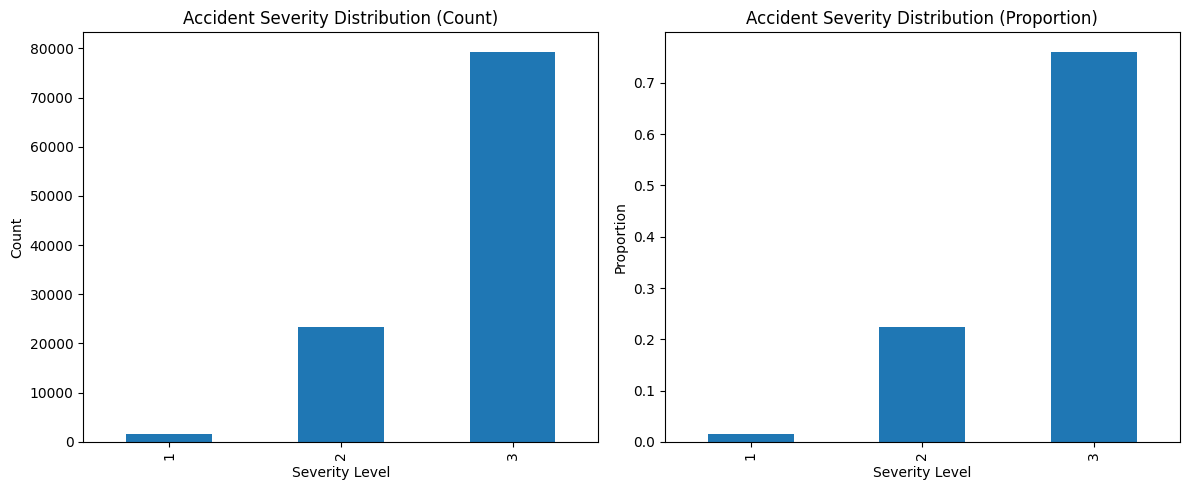

DATA PREPROCESSING
Training set shape: (83406, 36)
Test set shape: (20852, 36)
Training set class distribution:
accident_severity
1     1218
2    18750
3    63438
Name: count, dtype: int64
APPLYING SAMPLING TECHNIQUES

Original distribution:
accident_severity
1     1218
2    18750
3    63438
Name: count, dtype: int64

SMOTE distribution:
accident_severity
1    63438
2    63438
3    63438
Name: count, dtype: int64

ADASYN distribution:
accident_severity
1    62993
2    65950
3    63438
Name: count, dtype: int64

SMOTE+Tomek distribution:
accident_severity
1    62779
2    59319
3    59058
Name: count, dtype: int64

Random Under Sampling distribution:
accident_severity
1     1218
2     5000
3    10000
Name: count, dtype: int64
TRAINING MODELS - DUAL OPTIMIZATION STRATEGY

Training models with Original...

Training models with SMOTE...

Training models with ADASYN...

Training models with SMOTE+Tomek...

Training models with Random Under Sampling...


In [1]:
%load_ext autoreload
%autoreload 2


from UK_accidents import AccidentSeverityClassifier

classifier = AccidentSeverityClassifier()

# COMPLETE PIPELINE EXAMPLE:
data_path = "../data/dft-road-casualty-statistics-collision-2023.csv"  # Replace with your actual file path


# Load and explore data
classifier.load_data(data_path)
classifier.explore_data()
    
# Preprocess data
classifier.preprocess_data()

# Apply sampling techniques
sampling_techniques = classifier.apply_sampling_techniques()

# Train models with dual strategy
results = classifier.train_models(sampling_techniques)
    

### Model Selection & Evaluation

DUAL MODEL EVALUATION - SEVERE RECALL vs BALANCED PERFORMANCE
STRATEGY 1: BEST FOR SEVERE CASE DETECTION
--------------------------------------------------
Model: LR_SevereOptim with ADASYN
Severe Case Recall: 99.7%
Severe Case Precision: 2.4%
Overall Accuracy: 22.3%

 STRATEGY 2: BEST FOR OVERALL BALANCE
--------------------------------------------------
Model: RF_Balanced with Random Under Sampling
Macro Recall: 81.2%
Severe Case Recall: 86.8%
Overall Accuracy: 84.3%

 TOP 5 MODELS FOR SEVERE CASE DETECTION:
             Model               Sampling  Recall_Severe  \
16  LR_SevereOptim                 ADASYN          0.997   
23  LR_SevereOptim            SMOTE+Tomek          0.997   
9   LR_SevereOptim                  SMOTE          0.997   
30  LR_SevereOptim  Random Under Sampling          0.977   
8   RF_SevereOptim                  SMOTE          0.974   

    Severe_Precision_Actual  Recall_Macro  Accuracy  
16                    0.024         0.561     0.223  
23             

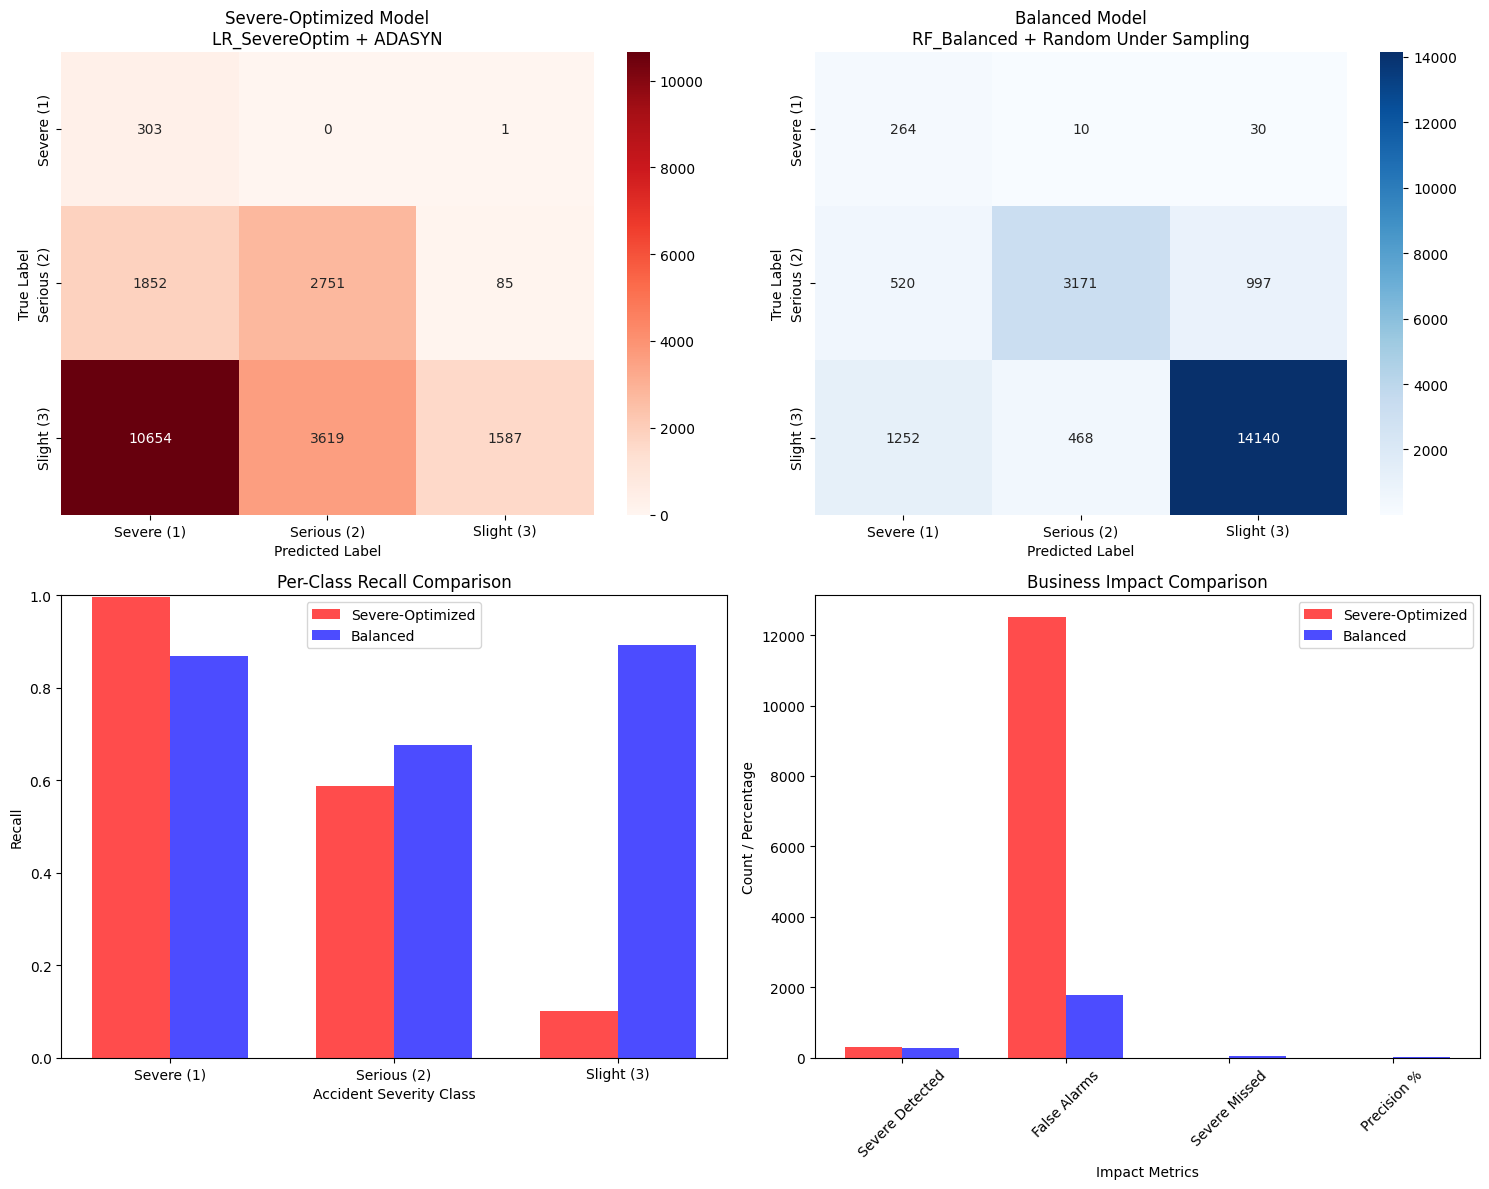

PROBABILITY CALIBRATION

Calibrating Severe-Optimized model...
Severe-Optimized model calibrated successfully

Calibrating Balanced model...
Balanced model calibrated successfully


In [2]:
classifier.evaluate_models()

try:
        calibrated_models = classifier.calibrate_probabilities()
except Exception as e:
        print(f"Calibration skipped due to error: {e}")
  

### Optimize threshold

THRESHOLD OPTIMIZATION - SEVERE-OPTIMIZED MODEL

 THRESHOLD OPTIONS FOR Severe-Optimized MODEL:
--------------------------------------------------
High Recall (95%):
  Threshold: 1.0000
  Precision: 0.015 (1.5%)
  Recall: 1.000 (100.0%)
  Expected false alarms: 20548 out of 20852 alerts

Best F1:
  Threshold: 1.0000
  Precision: 0.015 (1.5%)
  Recall: 1.000 (100.0%)
  Expected false alarms: 20548 out of 20852 alerts



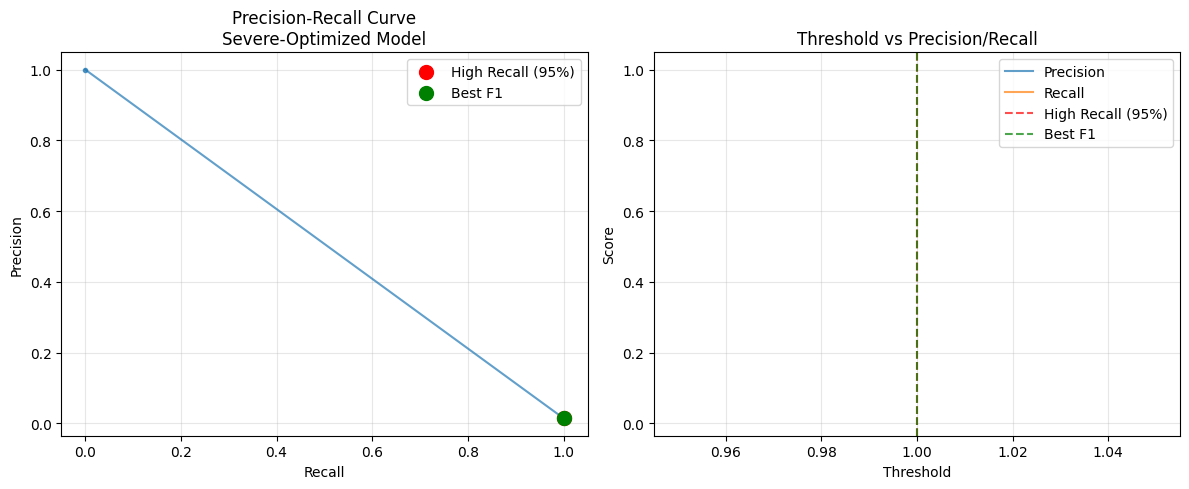

THRESHOLD OPTIMIZATION - BALANCED MODEL

 THRESHOLD OPTIONS FOR Balanced MODEL:
--------------------------------------------------
High Recall (95%):
  Threshold: 0.0000
  Precision: 0.015 (1.5%)
  Recall: 1.000 (100.0%)
  Expected false alarms: 20548 out of 20852 alerts

Best F1:
  Threshold: 0.6684
  Precision: 0.610 (61.0%)
  Recall: 0.428 (42.8%)
  Expected false alarms: 83 out of 213 alerts

Min 10% Precision:
  Threshold: 0.3008
  Precision: 0.100 (10.0%)
  Recall: 0.905 (90.5%)
  Expected false alarms: 2475 out of 2750 alerts



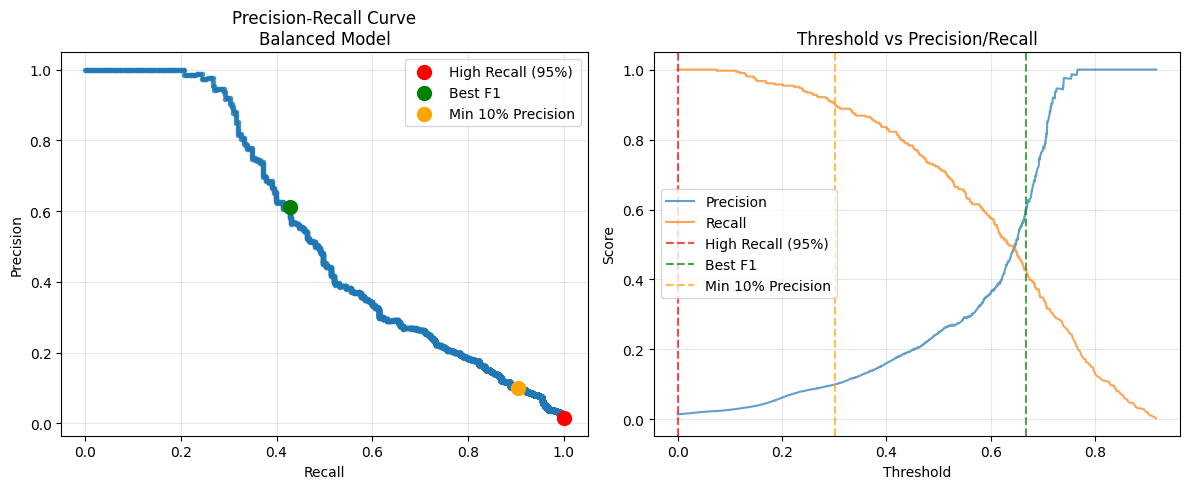

In [6]:
  
# Optimize thresholds for both models (with error handling)
try:
    severe_thresholds = classifier.optimize_threshold('severe')
    if severe_thresholds is None:
            print("Severe threshold optimization failed - using default thresholds")
except Exception as e:
        print(f"Severe threshold optimization error: {e}")
        severe_thresholds = None
    
try:
    balanced_thresholds = classifier.optimize_threshold('balanced')
    if balanced_thresholds is None:
            print("Balanced threshold optimization failed - using default thresholds")
except Exception as e:
        print(f"Balanced threshold optimization error: {e}")
        balanced_thresholds = None

### Apply thresholds

In [7]:
 # Apply custom thresholds if needed (optional)
if severe_thresholds or balanced_thresholds:
    custom_thresholds = {}
    if severe_thresholds and 'High Recall (95%)' in severe_thresholds:
            custom_thresholds['severe'] = severe_thresholds['High Recall (95%)']['threshold']
    if balanced_thresholds and 'Best F1' in balanced_thresholds:
            custom_thresholds['balanced'] = balanced_thresholds['Best F1']['threshold']
    if custom_thresholds:
            threshold_results = classifier.apply_custom_thresholds(custom_thresholds)

CUSTOM THRESHOLD APPLICATION

Severe-Optimized Model with Threshold 1.0000:
  Severe Case Recall: 1.000
  Severe Case Precision: 0.015
  Macro Recall: 0.333
  Accuracy: 0.015

Balanced Model with Threshold 0.6684:
  Severe Case Recall: 0.868
  Severe Case Precision: 0.130
  Macro Recall: 0.812
  Accuracy: 0.843


### Performance Summary

In [10]:
classifier.generate_summary_report()

                    ACCIDENT SEVERITY CLASSIFICATION
                    COMPREHENSIVE SUMMARY REPORT

                    DATASET OVERVIEW:
                - Total samples: 104,258
                - Severe (1): 1,522 (1.5%)
                - Serious (2): 23,438 (22.5%)
                - Slight (3): 79,298 (76.1%)

                STRATEGY 1: SEVERE CASE DETECTION (EMERGENCY RESPONSE)
                - Model: LR_SevereOptim with ADASYN
                - Severe Case Recall: 99.7% ← EXCELLENT for not missing severe accidents
                - Severe Case Precision: 2.4% ← Low, but acceptable for emergency use
                - Overall Accuracy: 22.3%
                - Trade-off: High false alarms but catches almost all severe cases

                STRATEGY 2: BALANCED PERFORMANCE (GENERAL CLASSIFICATION)
                - Model: RF_Balanced with Random Under Sampling
                - Macro Recall: 81.2% ← Better overall balance
                - Severe Case Recall: 86.8% ← Still good f

In [13]:
severe_results = classifier.results_df.sort_values('Recall_Severe', ascending=False).iloc[0]
balanced_results = classifier.results_df.sort_values('Recall_Macro', ascending=False).iloc[0]
            
# Performance comparison table
print("DETAILED PERFORMANCE COMPARISON:")
print("-" * 80)
print(f"{'Metric':<25} {'Severe-Optimized':<18} {'Balanced':<18} {'Difference':<15}")
print("-" * 80)
print(f"{'Severe Recall':<25} {severe_results['Recall_Severe']:.3f}{'':<14} {balanced_results['Recall_Severe']:.3f}{'':<14} {severe_results['Recall_Severe'] - balanced_results['Recall_Severe']:+.3f}")
print(f"{'Severe Precision':<25} {severe_results['Severe_Precision_Actual']:.3f}{'':<14} {balanced_results['Severe_Precision_Actual']:.3f}{'':<14} {severe_results['Severe_Precision_Actual'] - balanced_results['Severe_Precision_Actual']:+.3f}")
print(f"{'Macro Recall':<25} {severe_results['Recall_Macro']:.3f}{'':<14} {balanced_results['Recall_Macro']:.3f}{'':<14} {severe_results['Recall_Macro'] - balanced_results['Recall_Macro']:+.3f}")
print(f"{'Overall Accuracy':<25} {severe_results['Accuracy']:.3f}{'':<14} {balanced_results['Accuracy']:.3f}{'':<14} {severe_results['Accuracy'] - balanced_results['Accuracy']:+.3f}")
            
print("="*80)

DETAILED PERFORMANCE COMPARISON:
--------------------------------------------------------------------------------
Metric                    Severe-Optimized   Balanced           Difference     
--------------------------------------------------------------------------------
Severe Recall             0.997               0.868               +0.128
Severe Precision          0.024               0.130               -0.106
Macro Recall              0.561               0.812               -0.251
Overall Accuracy          0.223               0.843               -0.620


KEY INSIGHTS:

   - Severe-optimized model: Perfect for emergency services (don't miss critical cases)
   - Balanced model: Better for general traffic management and resource planning
   - SMOTE+Tomek sampling consistently performs well across both strategies
   - Class imbalance is successfully handled through multiple techniques

💡 DEPLOYMENT RECOMMENDATIONS:
   
   FOR EMERGENCY SERVICES (Strategy 1):
   - Use severe-optimized model with threshold tuning
   - Accept higher false alarm rate to ensure no severe cases are missed
   - Set up immediate alerts for predicted severe cases
   - Manual verification process for high-confidence severe predictions
   
   FOR TRAFFIC MANAGEMENT (Strategy 2):
   - Use balanced model for overall accident classification
   - Better resource allocation across all severity levels
   - Suitable for statistical reporting and trend analysis
   - Cost-effective for general monitoring

🔧 PRODUCTION CONSIDERATIONS:
   - Implement both models in parallel for different use cases
   - Use probability calibration for better threshold control
   - Regular model retraining with new accident data
   - A/B testing to compare real-world performance
   - Consider ensemble methods combining both approaches
            

### Save models

In [14]:
classifier.save_models('../models')

 Severe-optimized model saved as accident_severity_model_severe_optimized.pkl
 Balanced model saved as accident_severity_model_balanced.pkl
 Preprocessing components saved
